# Tutorial 2

* Reference Model 3 (RM3)
* two bodies, 7 DOFs
* PTO is based on reltative motion of 2 WEC DOFs
* Multidirectional, irregular waves

In [2]:
import os
import logging

import autograd.numpy as np
from autograd.builtins import isinstance, tuple, list, dict
import capytaine as cpy
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

import wecopttool as wot


logging.basicConfig(level=logging.INFO)

Select the number of DOFS.
Options:

* 2 DOFs: Spar Heave, Float Heave
* 4 DOFs: Spar Heave, Float Heave, Combined Surge, Combined Pitch
* 7 DOFs: Spar Heave, Float Heave, Combined Surge, Combined Sway, Combined Roll, Combined Pitch, Combined Yaw

In [1]:
ndof = 4

* Definitions we'll need later

In [3]:
def parallel_ax(inertia, mass, distance_vec):
    r = np.reshape(distance_vec, (3, 1))
    r2 = (r.T @ r) * np.eye(3) - r @ r.T
    return inertia + mass * r2


def idx(body, dof):
    return 6 * body + dof


bodies = {'float': 0, 'spar': 1, 'rm3': 2}
dofs = {'SURGE': 0, 'SWAY': 1, 'HEAVE': 2, 'ROLL': 3, 'PITCH': 4, 'YAW': 5}

* mesh files

In [4]:
mesh_dir = 'data'
mesh_float = 'rm3_float.stl'
mesh_spar = 'rm3_spar.stl'
mesh_float = os.path.join(mesh_dir, mesh_float)
mesh_spar = os.path.join(mesh_dir, mesh_spar)


* mass properties of RM3

In [5]:
float_cog = np.array([0.0, 0.0, -0.7200])
float_moi = np.diag([20907301, 21306090.66, 37085481.11])
spar_cog = np.array([0.0, 0.0, -21.2900])
spar_moi = np.diag([94419614.57, 94407091.24, 28542224.82])

* Change default water density

In [6]:
rho = 1000

* case selection

In [7]:
if ndof == 2:
    rm3_translation_dofs = []
    rm3_rotation_dofs = []
    dof_idx = [1, 1, 0, 0, 0, 0, 0]
elif ndof == 4:
    rm3_translation_dofs = ['SURGE']
    rm3_rotation_dofs = ['PITCH']
    dof_idx = [1, 1, 1, 0, 0, 1, 0]
elif ndof == 7:
    rm3_translation_dofs = ['SURGE', 'SWAY']
    rm3_rotation_dofs = ['ROLL', 'PITCH', 'YAW']
    dof_idx = [1, 1, 1, 1, 1, 1, 1]
else:
    raise ValueError('`ndof` must be 2, 4 or 7.')
rm3_dofs = rm3_translation_dofs + rm3_rotation_dofs
rm3_ndofs = len(rm3_dofs)

* Calculate the mass and hydrostatic properties of each body separately, and of the two bodies combined
* Create the individual and combined Capytaine floating body 

In [8]:
# float - heave
float_fb = cpy.FloatingBody.from_file(
    mesh_float, name='float').translate(float_cog)
float_fb.add_translation_dof(name="HEAVE")

# float mass & stiffness
float_hs_data = wot.hydrostatics.hydrostatics(float_fb, rho=rho)
float_stiffness = wot.hydrostatics.stiffness_matrix(float_hs_data)
float_mass = wot.hydrostatics.mass_matrix_constant_density(float_hs_data)
float_lmass = float_mass[0, 0]
float_mass[3:, 3:] = float_moi

# spar - heave
spar_fb = cpy.FloatingBody.from_file(
    mesh_spar, name='spar').translate(spar_cog)
spar_fb.add_translation_dof(name="HEAVE")

# spar - mass & stiffness
spar_hs_data = wot.hydrostatics.hydrostatics(spar_fb, rho=rho)
spar_stiffness = wot.hydrostatics.stiffness_matrix(spar_hs_data)
spar_mass = wot.hydrostatics.mass_matrix_constant_density(spar_hs_data)
spar_lmass = spar_mass[0, 0]
spar_mass[3:, 3:] = spar_moi

# RM3
rm3_fb = float_fb + spar_fb

# RM3 - translation DOFs
for dof in rm3_translation_dofs:
    rm3_fb.add_translation_dof(name=dof)

# RM3 - mass & stiffness
rm3_lmass = float_lmass + spar_lmass
rm3_cog = (float_lmass*float_cog + spar_lmass*spar_cog) / rm3_lmass
moi_1 = parallel_ax(float_moi, float_lmass, float_cog - rm3_cog)
moi_2 = parallel_ax(spar_moi, spar_lmass, spar_cog - rm3_cog)
rm3_moi = moi_1 + moi_2
rm3_mass = block_diag(rm3_lmass, rm3_lmass, rm3_lmass, rm3_moi)
rm3_hs_data = wot.hydrostatics.hydrostatics(rm3_fb, rho=rho)
rm3_stiffness = wot.hydrostatics.stiffness_matrix(rm3_hs_data)

# RM3 - rotation DOFs
rm3_fb.rotation_center = rm3_cog
for dof in rm3_rotation_dofs:
    rm3_fb.add_rotation_dof(name=dof)

# mass & hydrostatic stiffness
mass_all = block_diag(float_mass, spar_mass, rm3_mass)
stiffness_all = block_diag(float_stiffness, spar_stiffness, rm3_stiffness)
idxs = np.array([
    [idx(bodies['float'], dofs['HEAVE']), idx(bodies['spar'], dofs['HEAVE'])] +
    [idx(bodies['rm3'], dofs[dof]) for dof in rm3_dofs]])
mass = mass_all[idxs.T, idxs]
stiffness = stiffness_all[idxs.T, idxs]

INFO:capytaine.bodies.bodies:New floating body: float.
INFO:capytaine.bodies.bodies:New floating body: spar.
INFO:capytaine.bodies.bodies:New floating body: float+spar.
INFO:capytaine.bodies.bodies:The rotation dof PITCH has been initialized around the point: float+spar.rotation_center = [  0.           0.         -12.15428067]


* PTO: we'll use a proportional controller PTO. The goal will be to find the PTO damping value that results in the most energy produced from the given wave.

In [9]:
kinematics = np.array([[1.0, -1.0] + [0.0]*rm3_ndofs])
pto = wot.pto.ProportionalPTO(kinematics)

* Define the pseudo-spectral frequencies
* Create the WEC instance

In [10]:
f0 = 0.0032
nfreq = 100

# WEC
f_add = pto.force_on_wec
wec = wot.WEC(rm3_fb, mass, stiffness, f0, nfreq, rho=rho, f_add=f_add)

INFO:wecopttool.core:New WEC: float+spar with 4 DOF.


* Create save directory

In [11]:
results_dir = 'results_tutorial_2'
if not os.path.exists(results_dir):
  os.makedirs(results_dir)


* Create the wave

In [12]:
peak_frequency = 1.0/8.0
significant_height = 2.5
directions = np.arange(-180, 180, 20.0)
mean_direction = 40.0
s_max = 10.0


def spectrum_func(f):
    spectrum = wot.waves.pierson_moskowitz_spectrum
    return spectrum(f, peak_frequency, significant_height)


def spread_func(f, d):
    return wot.waves.spread_cos2s(f, d, mean_direction, peak_frequency, s_max)


spectrum_name = 'JONSWAP'
spread_name = 'Cos-2S'
waves = wot.waves.irregular_wave(
    f0, nfreq, directions, spectrum_func, spread_func,
    spectrum_name, spread_name)


* BEM

In [13]:
fname = os.path.join(results_dir, 'bem.nc')
if os.path.exists(fname):
    wec.read_bem(fname)
else:
    wec.run_bem(wave_dirs=waves['wave_direction'].values)
    wec.write_bem(fname)

INFO:wecopttool.core:Reading BEM data from results_tutorial_2/bem.nc.
INFO:wecopttool.core:  Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Calculating impedance matrix.
INFO:capytaine.post_pro.impedance:Compute impedance.


* Solve
* postporocess optimal PTO results

In [14]:
options = {'maxiter': 1000, 'ftol': 1e-8}
scale_x_opt = 1000
obj_fun = pto.energy
nstate_opt = pto.nstate
maximize = True
wec_tdom, wec_fdom, x_wec, x_opt, obj, res = wec.solve(
    waves, obj_fun, nstate_opt, optim_options=options, maximize=maximize,
    scale_x_opt=scale_x_opt)

pto_tdom, pto_fdom = pto.post_process(wec, x_wec, x_opt)

INFO:wecopttool.core:Solving pseudo-spectral control problem.


Iteration limit reached    (Exit mode 9)
            Current function value: -98787516.95671399
            Iterations: 1000
            Function evaluations: 3080
            Gradient evaluations: 1000


## Results

* Print
* Save

In [15]:
# print
print(f"\nEnergy produced from 0-{wec.tf}s: {obj} J")
print(f"Average power: {obj/wec.tf} W\n")

# save
fname = os.path.join(results_dir, 'wec_tdom.nc')
wec_tdom.to_netcdf(fname)

fname = os.path.join(results_dir, 'wec_fdom.nc')
wot.complex_xarray_to_netcdf(fname, wec_fdom)

fname = os.path.join(results_dir, 'pto_tdom.nc')
pto_tdom.to_netcdf(fname)

fname = os.path.join(results_dir, 'pto_fdom.nc')
wot.complex_xarray_to_netcdf(fname, pto_fdom)



Energy produced from 0-312.5s: 98787516.95671399 J
Average power: 316120.05426148477 W



* View mesh (close pop-up window before continuing)

In [19]:
wec.fb.show()

* Plot impedance

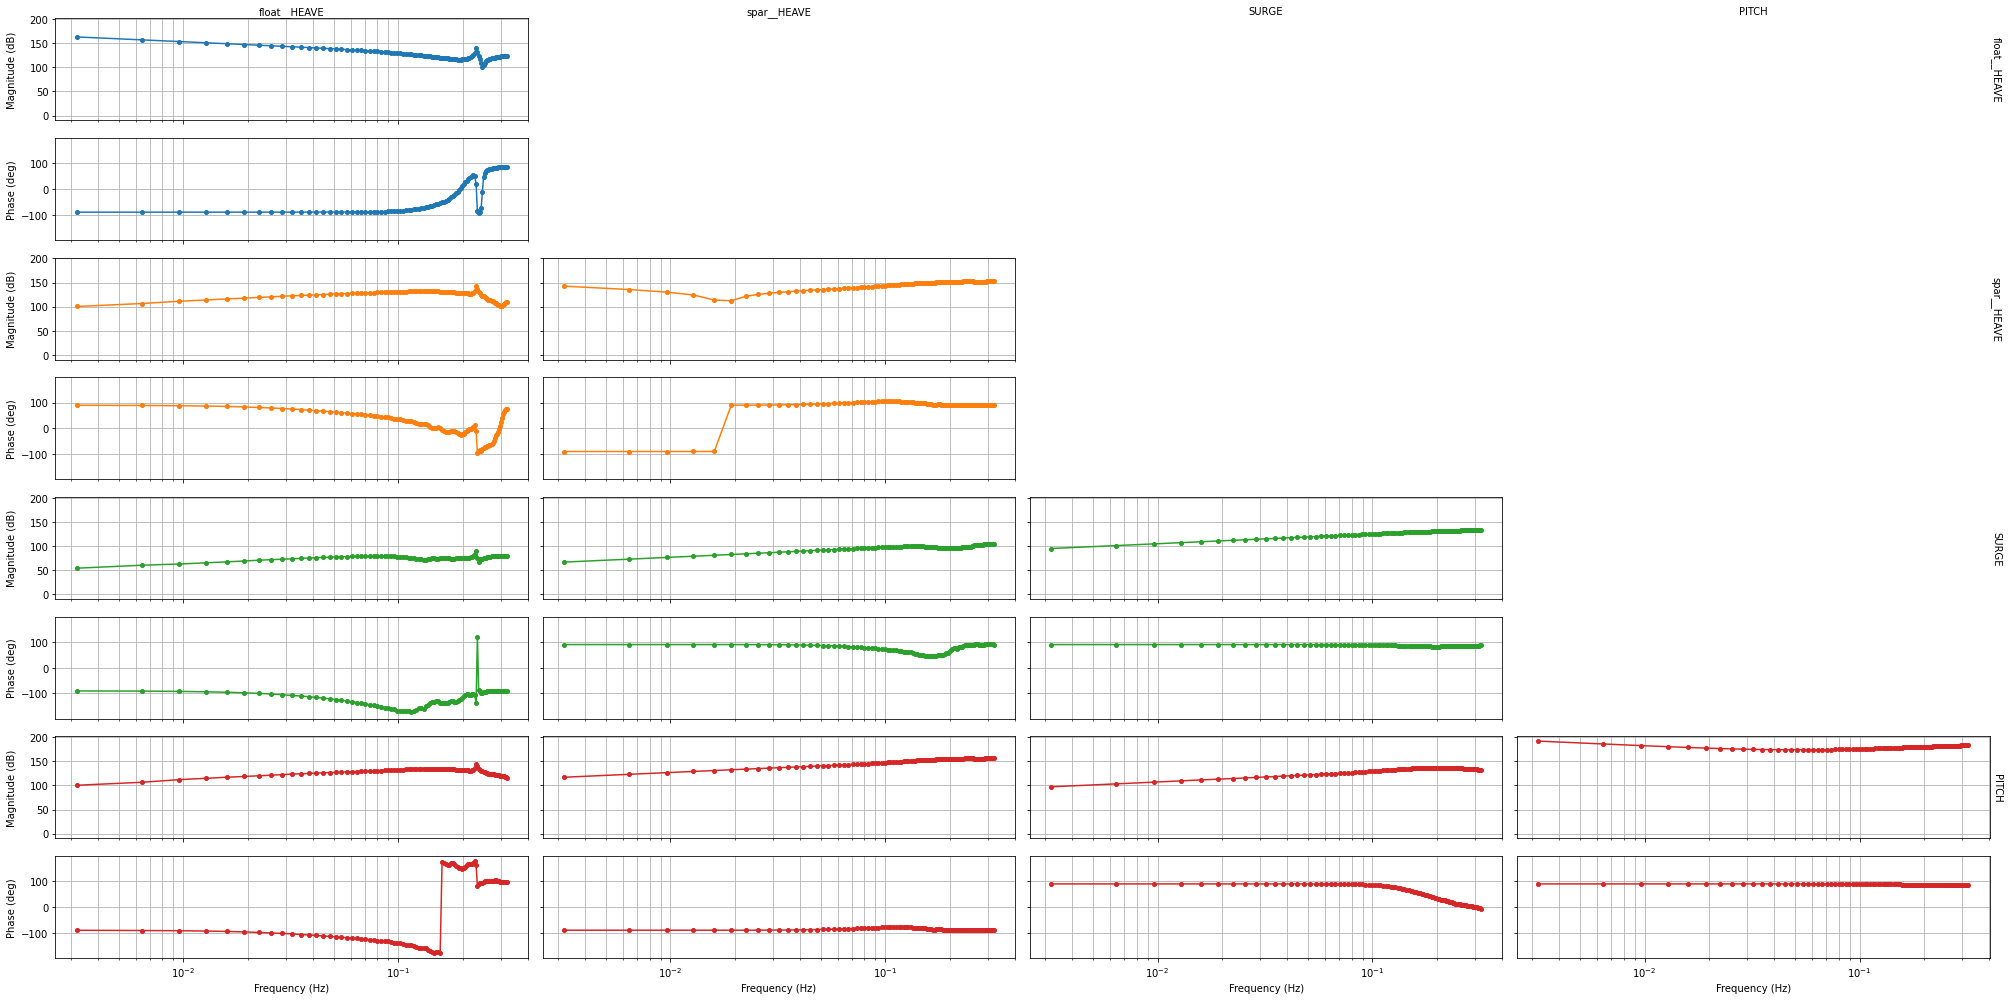

(<Figure size 2016x1008 with 36 Axes>,
 array([[<AxesSubplot:xlabel='float__HEAVE', ylabel='Magnitude (dB)'>,
         <AxesSubplot:xlabel='spar__HEAVE'>, <AxesSubplot:xlabel='SURGE'>,
         <AxesSubplot:xlabel='PITCH'>],
        [<AxesSubplot:ylabel='Phase (deg)'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='Magnitude (dB)'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='Phase (deg)'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='Magnitude (dB)'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='Phase (deg)'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='Magnitude (dB)'>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='Frequency (Hz)', ylabel='Phase (deg)'>,
         <AxesSubplot:xlabel='Frequency (Hz)'>,
         <AxesSubplot:xlabel='

In [20]:
wec.plot_impedance()

* Example time-domain plots

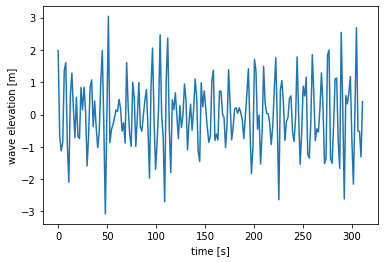

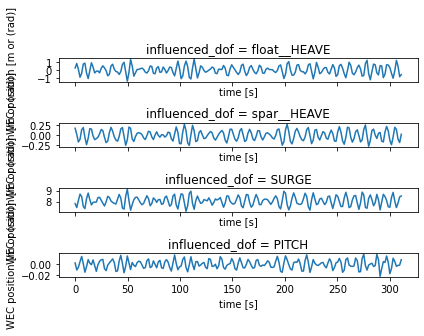

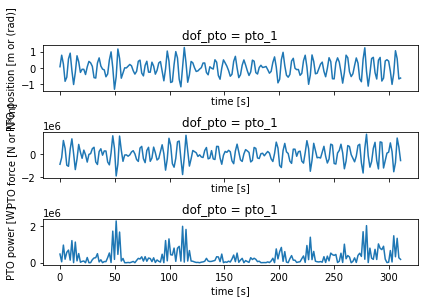

In [21]:
# wave elevation
plt.figure()
wec_tdom['wave_elevation'].plot()

# WEC positions (1 fig, ndof subplots)
fig, axs = plt.subplots(nrows=ndof, sharex=True)
wec_tdom['pos'].sel(influenced_dof="float__HEAVE").plot(ax=axs[0])
wec_tdom['pos'].sel(influenced_dof="spar__HEAVE").plot(ax=axs[1])
if ndof == 4 or ndof == 7:
    wec_tdom['pos'].sel(influenced_dof="SURGE").plot(ax=axs[2])
    wec_tdom['pos'].sel(influenced_dof="PITCH").plot(ax=axs[3])
if ndof == 7:
    wec_tdom['pos'].sel(influenced_dof="SWAY").plot(ax=axs[4])
    wec_tdom['pos'].sel(influenced_dof="ROLL").plot(ax=axs[5])
    wec_tdom['pos'].sel(influenced_dof="YAW").plot(ax=axs[6])
fig.align_ylabels(axs)
fig.tight_layout()

# PTO extension, force, power (1 figure)
fig, axs = plt.subplots(nrows=3, sharex=True)
pto_tdom['pos'].plot(ax=axs[0])
pto_tdom['force'].plot(ax=axs[1])
pto_tdom['power'].plot(ax=axs[2])
fig.align_ylabels(axs)
fig.tight_layout()

plt.show()

* Example frequency-domain plots (excitation force, PTO extension) (tricky because of multiple wave directions)